In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score, f1_score,confusion_matrix,precision_score, recall_score,roc_auc_score,precision_recall_curve,balanced_accuracy_score
import optuna
import plotly

In [5]:
df=pd.read_csv('CICIDS2018/02-14-2018.csv')

In [6]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [7]:
df.shape

(1048575, 80)

In [8]:
df['Label'].value_counts()

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [9]:
df.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [10]:
col=df.columns
col

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [11]:
df=df.drop(columns='Timestamp')

In [12]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,112641719,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,112641466,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,112638623,3,0,0,0,0,0,0.000000,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,6453966,15,10,1239,2273,744,0,82.600000,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,8804066,14,11,1143,2209,744,0,81.642857,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [13]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Byts/b Avg',
 'Fwd Pkts/b Avg',
 'Fwd Blk Rate Avg',
 'Bwd Byts/b Avg',
 'Bwd Pkts/b Avg',
 'Bwd Blk Rate Avg']

In [14]:
df=df.drop(columns=zero_variance_cols)

In [15]:
zero_variance_cols = [col for col in df.columns if df[col].nunique() <= 1]
zero_variance_cols

[]

In [16]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index(['Flow Byts/s', 'Flow Pkts/s'], dtype='object')

In [17]:
df['Flow Byts/s'] = df['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)
df['Flow Pkts/s'] = df['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

In [18]:
df['Flow Byts/s'] = df['Flow Byts/s'].fillna(0)
df['Flow Pkts/s'] = df['Flow Pkts/s'].fillna(0)

In [19]:
inf_nan_cols = df.columns[df.isin([np.inf, -np.inf]).any() | df.isna().any()]
inf_nan_cols

Index([], dtype='object')

In [20]:
df_benign = df[df['Label'] == 'Benign']
df_attack = df[df['Label'] != 'Benign']

In [21]:
df_benign['Label'].value_counts()

Label
Benign    667626
Name: count, dtype: int64

In [22]:
df_attack['Label'].value_counts()

Label
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [23]:
print(df_benign.shape,df_attack.shape)

(667626, 69) (380949, 69)


In [24]:
# 1. Split Benign into Train and Temp (for Val/Test)
X_benign_train, X_benign_temp = train_test_split(df_benign, test_size=0.3, random_state=42)

# 2. Split Temp Benign into Validation and Test
X_benign_val, X_benign_test = train_test_split(X_benign_temp, test_size=0.5, random_state=42)

# 3. Split Attack Data into Validation and Test
df_attack_val, df_attack_test = train_test_split(df_attack, test_size=0.5, random_state=42)

# 4. Construct the Sets
# TRAIN: Pure Benign
X_train = X_benign_train.drop(columns=['Label'])

# VALIDATION: Mixed (Used for Optuna & Threshold Tuning)
val_df = pd.concat([X_benign_val, df_attack_val])
X_val = val_df.drop(columns=['Label'])
y_val = val_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

# TEST: Mixed (Used ONLY for final report)
test_df = pd.concat([X_benign_test, df_attack_test])
X_test = test_df.drop(columns=['Label'])
y_test = test_df['Label'].apply(lambda x: 0 if x=='Benign' else 1)

In [25]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [40]:
def objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_samples': trial.suggest_float('max_samples', 0.3, 1.0),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    
    # Train model (contamination is dummy since we'll use custom threshold)
    model = IsolationForest(
        **params,
        contamination='auto',  
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train_scaled)
    
    # Get scores on VALIDATION set
    raw_scores = model.decision_function(X_val_scaled)
    
    # Invert scores: HIGH positive = anomaly, LOW negative = normal
    y_scores = -1 * raw_scores
    
    # Calculate ROC-AUC on validation set
    auc = roc_auc_score(y_val, y_scores)
    
    return auc

In [41]:
print("Starting Optuna optimization (30 trials)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-12-20 22:39:28,944] A new study created in memory with name: no-name-4670a34e-6839-4d4a-9c6c-3abe1d1ac64f


Starting Optuna optimization (30 trials)...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-20 22:40:08,080] Trial 0 finished with value: 0.9750405991283175 and parameters: {'n_estimators': 331, 'max_samples': 0.655358020281297, 'max_features': 0.802363304663879, 'bootstrap': False}. Best is trial 0 with value: 0.9750405991283175.
[I 2025-12-20 22:40:28,466] Trial 1 finished with value: 0.9797363321015267 and parameters: {'n_estimators': 184, 'max_samples': 0.9451394937535083, 'max_features': 0.534453163916367, 'bootstrap': False}. Best is trial 1 with value: 0.9797363321015267.
[I 2025-12-20 22:40:37,297] Trial 2 finished with value: 0.9488053469790569 and parameters: {'n_estimators': 110, 'max_samples': 0.3245229466740753, 'max_features': 0.6220699525650866, 'bootstrap': True}. Best is trial 1 with value: 0.9797363321015267.
[I 2025-12-20 22:40:42,898] Trial 3 finished with value: 0.9782093704634403 and parameters: {'n_estimators': 50, 'max_samples': 0.9981442997539658, 'max_features': 0.6630150521135802, 'bootstrap': False}. Best is trial 1 with value: 0.9797363

In [42]:
print(f"Best ROC-AUC: {study.best_trial.value:.4f}")
print(f"Best Parameters: {study.best_trial.params}")
best_params = study.best_trial.params

Best ROC-AUC: 0.9836
Best Parameters: {'n_estimators': 61, 'max_samples': 0.8651222794501894, 'max_features': 0.362541686097377, 'bootstrap': False}


C:\Users\Mominul Hoque\AppData\Local\Temp\ipykernel_12092\199994575.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

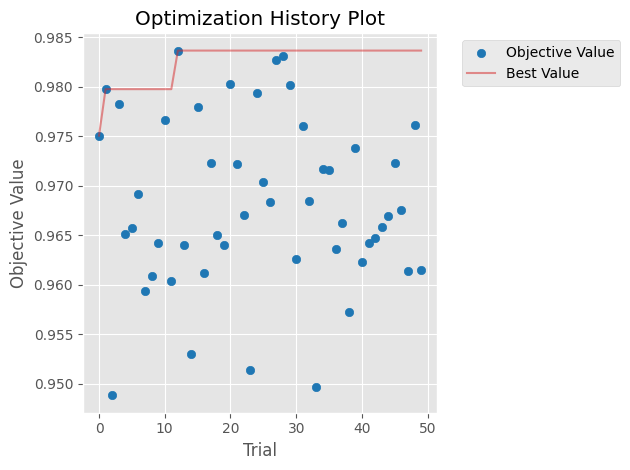

In [43]:
from optuna.visualization.matplotlib import plot_optimization_history
plot_optimization_history(study)

In [44]:
final_model = IsolationForest(
    **best_params,
    contamination='auto',  # Dummy (using custom threshold)
    random_state=42,
    n_jobs=-1
)

print("Training on full training set...")
final_model.fit(X_train_scaled)

Training on full training set...


IsolationForest(max_features=0.362541686097377, max_samples=0.8651222794501894,
                n_estimators=61, n_jobs=-1, random_state=42)

In [45]:
print("\nFinding optimal threshold using VALIDATION set...")

# Get validation scores
val_raw_scores = final_model.decision_function(X_val_scaled)
val_y_scores = -1 * val_raw_scores  # Invert: HIGH = anomaly

# Use Precision-Recall curve to find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_y_scores)

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]
best_val_f1 = f1_scores[best_idx]


Finding optimal threshold using VALIDATION set...


In [46]:
print(f"   Validation F1: {best_val_f1:.4f}")
print(f"   Validation Precision: {precision[best_idx]:.4f}")
print(f"   Validation Recall: {recall[best_idx]:.4f}")

   Validation F1: 0.9838
   Validation Precision: 0.9787
   Validation Recall: 0.9889


In [48]:
print(f"The Optimal Anomaly Threshold is: {optimal_threshold:.6f}")

The Optimal Anomaly Threshold is: -0.121480


In [47]:
# Get test scores
test_raw_scores = final_model.decision_function(X_test_scaled)
test_y_scores = -1 * test_raw_scores

# Apply optimal threshold
final_predictions = (test_y_scores >= optimal_threshold).astype(int)

# Calculate comprehensive metrics
test_f1 = f1_score(y_test, final_predictions)
test_auc = roc_auc_score(y_test, test_y_scores)
test_balanced_acc = balanced_accuracy_score(y_test, final_predictions)

In [49]:
print(f"   F1 Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")

   F1 Score: 0.9841
   ROC-AUC: 0.9838
   Balanced Accuracy: 0.9744


In [50]:
print(classification_report(
    y_test, 
    final_predictions,
    target_names=['Benign (0)', 'Attack (1)'],
    digits=4
))

              precision    recall  f1-score   support

  Benign (0)     0.9793    0.9594    0.9693    100144
  Attack (1)     0.9789    0.9893    0.9841    190475

    accuracy                         0.9790    290619
   macro avg     0.9791    0.9744    0.9767    290619
weighted avg     0.9790    0.9790    0.9790    290619



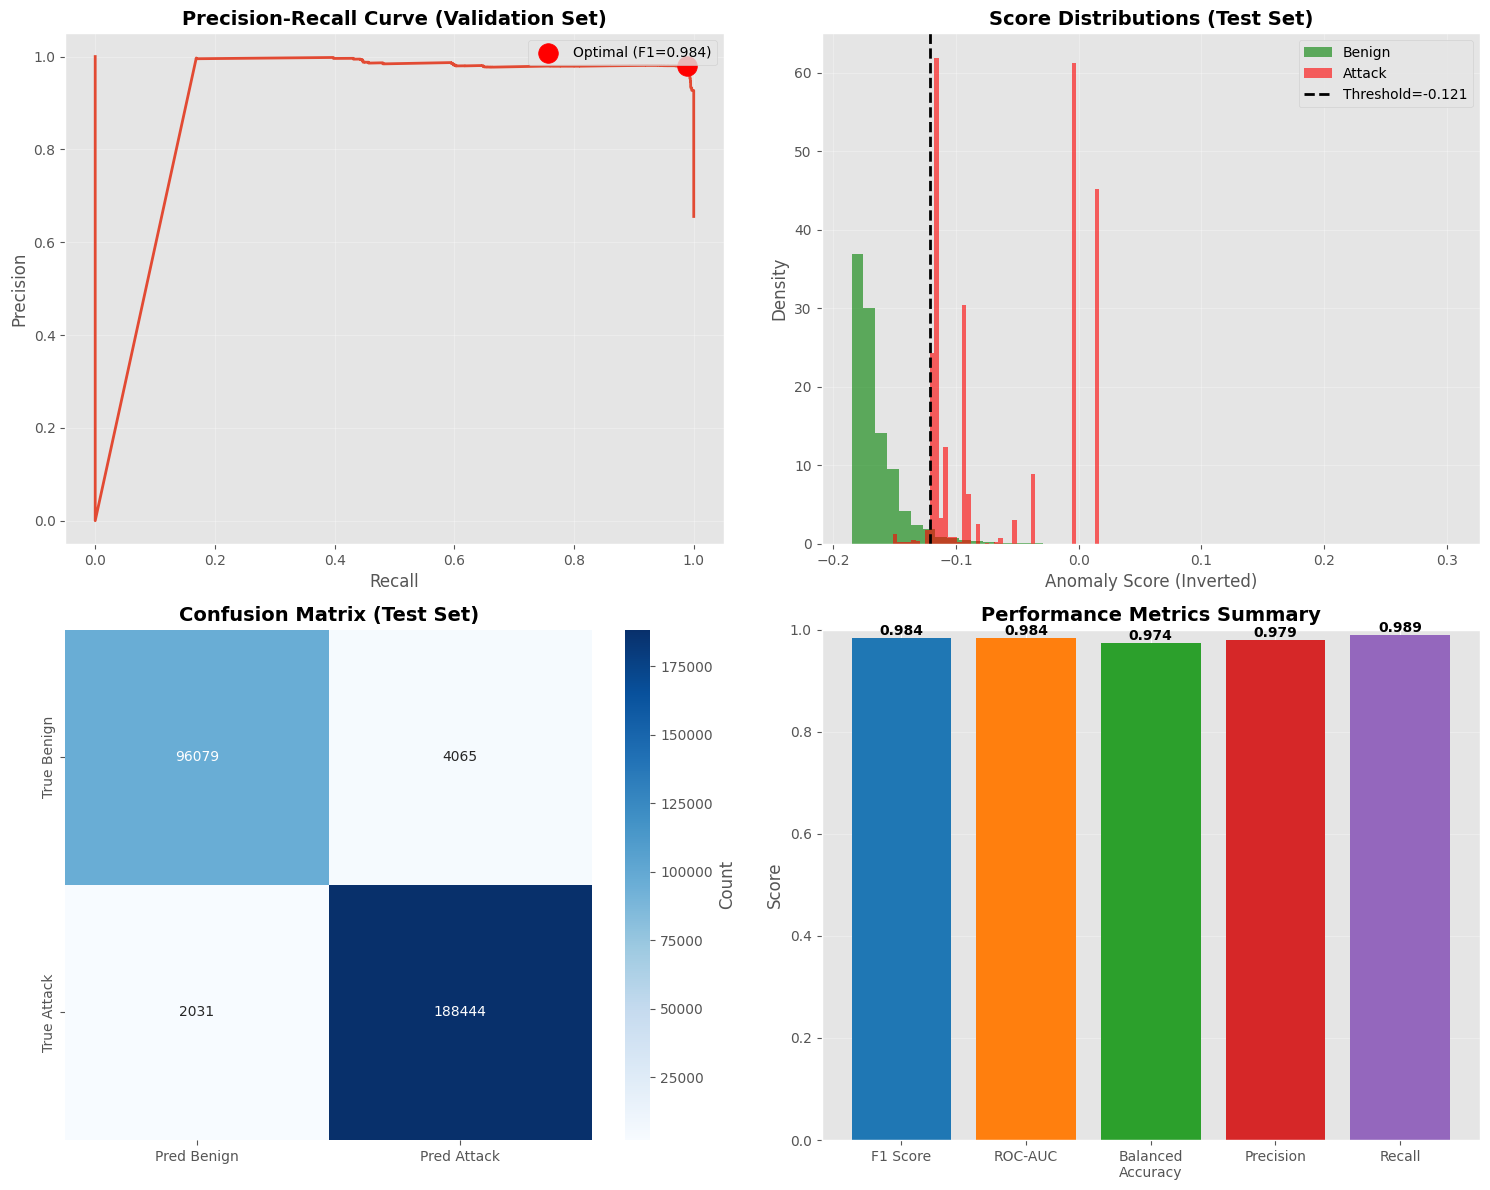

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2)
ax1.scatter(
    recall[best_idx], 
    precision[best_idx], 
    color='red', 
    s=200, 
    zorder=5,
    label=f'Optimal (F1={best_val_f1:.3f})'
)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve (Validation Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Score Distribution
ax2 = axes[0, 1]
ax2.hist(
    test_y_scores[y_test==0], 
    bins=50, 
    alpha=0.6, 
    label='Benign', 
    color='green',
    density=True
)
ax2.hist(
    test_y_scores[y_test==1], 
    bins=50, 
    alpha=0.6, 
    label='Attack', 
    color='red',
    density=True
)
ax2.axvline(
    optimal_threshold, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Threshold={optimal_threshold:.3f}'
)
ax2.set_xlabel('Anomaly Score (Inverted)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Score Distributions (Test Set)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax3,
    xticklabels=['Pred Benign', 'Pred Attack'],
    yticklabels=['True Benign', 'True Attack'],
    cbar_kws={'label': 'Count'}
)
ax3.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# Plot 4: Metrics Comparison
ax4 = axes[1, 1]
metrics = {
    'F1 Score': test_f1,
    'ROC-AUC': test_auc,
    'Balanced\nAccuracy': test_balanced_acc,
    'Precision': precision[best_idx],
    'Recall': recall[best_idx]
}
bars = ax4.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
def objective_ocsvm(trial):
    params = {
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'nu': trial.suggest_float('nu', 0.01, 0.3)
    }
    
    # For large datasets, use subset for SVM training
    sample_size = min(10000, len(X_train_scaled))
    indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
    X_train_sample = X_train_scaled[indices]
    
    model = OneClassSVM(**params)
    model.fit(X_train_sample)
    
    # Predict on validation set
    raw_scores = model.decision_function(X_val_scaled)
    y_scores = -1 * raw_scores  # Invert for consistency
    auc = roc_auc_score(y_val, y_scores)
    
    return auc

In [27]:
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(objective_ocsvm, n_trials=20, show_progress_bar=True)

[I 2025-12-20 21:08:05,625] A new study created in memory with name: no-name-7a170ba7-753d-4e52-adbb-7740115e3ffd


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-20 21:11:11,124] Trial 0 finished with value: 0.8817248089879735 and parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.03573737016316235}. Best is trial 0 with value: 0.8817248089879735.
[I 2025-12-20 21:14:10,811] Trial 1 finished with value: 0.8752670913431894 and parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.07993450925231278}. Best is trial 0 with value: 0.8817248089879735.
[I 2025-12-20 21:14:54,545] Trial 2 finished with value: 0.45180761982950773 and parameters: {'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.2782845915623761}. Best is trial 0 with value: 0.8817248089879735.
[I 2025-12-20 21:18:04,976] Trial 3 finished with value: 0.880013447576909 and parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.12240498902632092}. Best is trial 0 with value: 0.8817248089879735.
[I 2025-12-20 21:18:34,725] Trial 4 finished with value: 0.43293127351762195 and parameters: {'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.17201941842356178}. Best is trial 0 with va

In [41]:
print(f"\nBest One-Class SVM AUC: {study_svm.best_trial.value:.4f}")
print(f"Best Parameters: {study_svm.best_trial.params}")


Best One-Class SVM AUC: 0.8823
Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'nu': 0.13886159029860867}


In [29]:
sample_size = min(50000, len(X_train_scaled))
indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_train_sample = X_train_scaled[indices]

In [30]:
best_ocsvm = OneClassSVM(**study_svm.best_trial.params)
print(f"\nTraining One-Class SVM on {sample_size} samples...")
best_ocsvm.fit(X_train_sample)


Training One-Class SVM on 50000 samples...


OneClassSVM(gamma='auto', nu=0.05535175744811061)

In [58]:
print("\nFinding optimal threshold using VALIDATION set...")

# Get validation scores
val_raw_scores = best_ocsvm.decision_function(X_val_scaled)
val_y_scores = -1 * val_raw_scores  # Invert: HIGH = anomaly

# Use Precision-Recall curve to find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, val_y_scores)

# Calculate F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
optimal_threshold_ocsvm = thresholds[best_idx]
best_val_f1 = f1_scores[best_idx]


Finding optimal threshold using VALIDATION set...


In [59]:
print(f"   Validation F1: {best_val_f1:.4f}")
print(f"   Validation Precision: {precision[best_idx]:.4f}")
print(f"   Validation Recall: {recall[best_idx]:.4f}")

   Validation F1: 0.9270
   Validation Precision: 0.9002
   Validation Recall: 0.9553


In [61]:
print(f"The Optimal Anomaly Threshold is: {optimal_threshold_ocsvm:.6f}")

The Optimal Anomaly Threshold is: 0.009098


In [62]:
# Get test scores
test_raw_scores = best_ocsvm.decision_function(X_test_scaled)
test_y_scores = -1 * test_raw_scores

# Apply optimal threshold
final_predictions = (test_y_scores >= optimal_threshold_ocsvm).astype(int)

# Calculate comprehensive metrics
test_f1 = f1_score(y_test, final_predictions)
test_auc = roc_auc_score(y_test, test_y_scores)
test_balanced_acc = balanced_accuracy_score(y_test, final_predictions)

In [63]:
print(f"   F1 Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")

   F1 Score: 0.9269
   ROC-AUC: 0.8693
   Balanced Accuracy: 0.8767


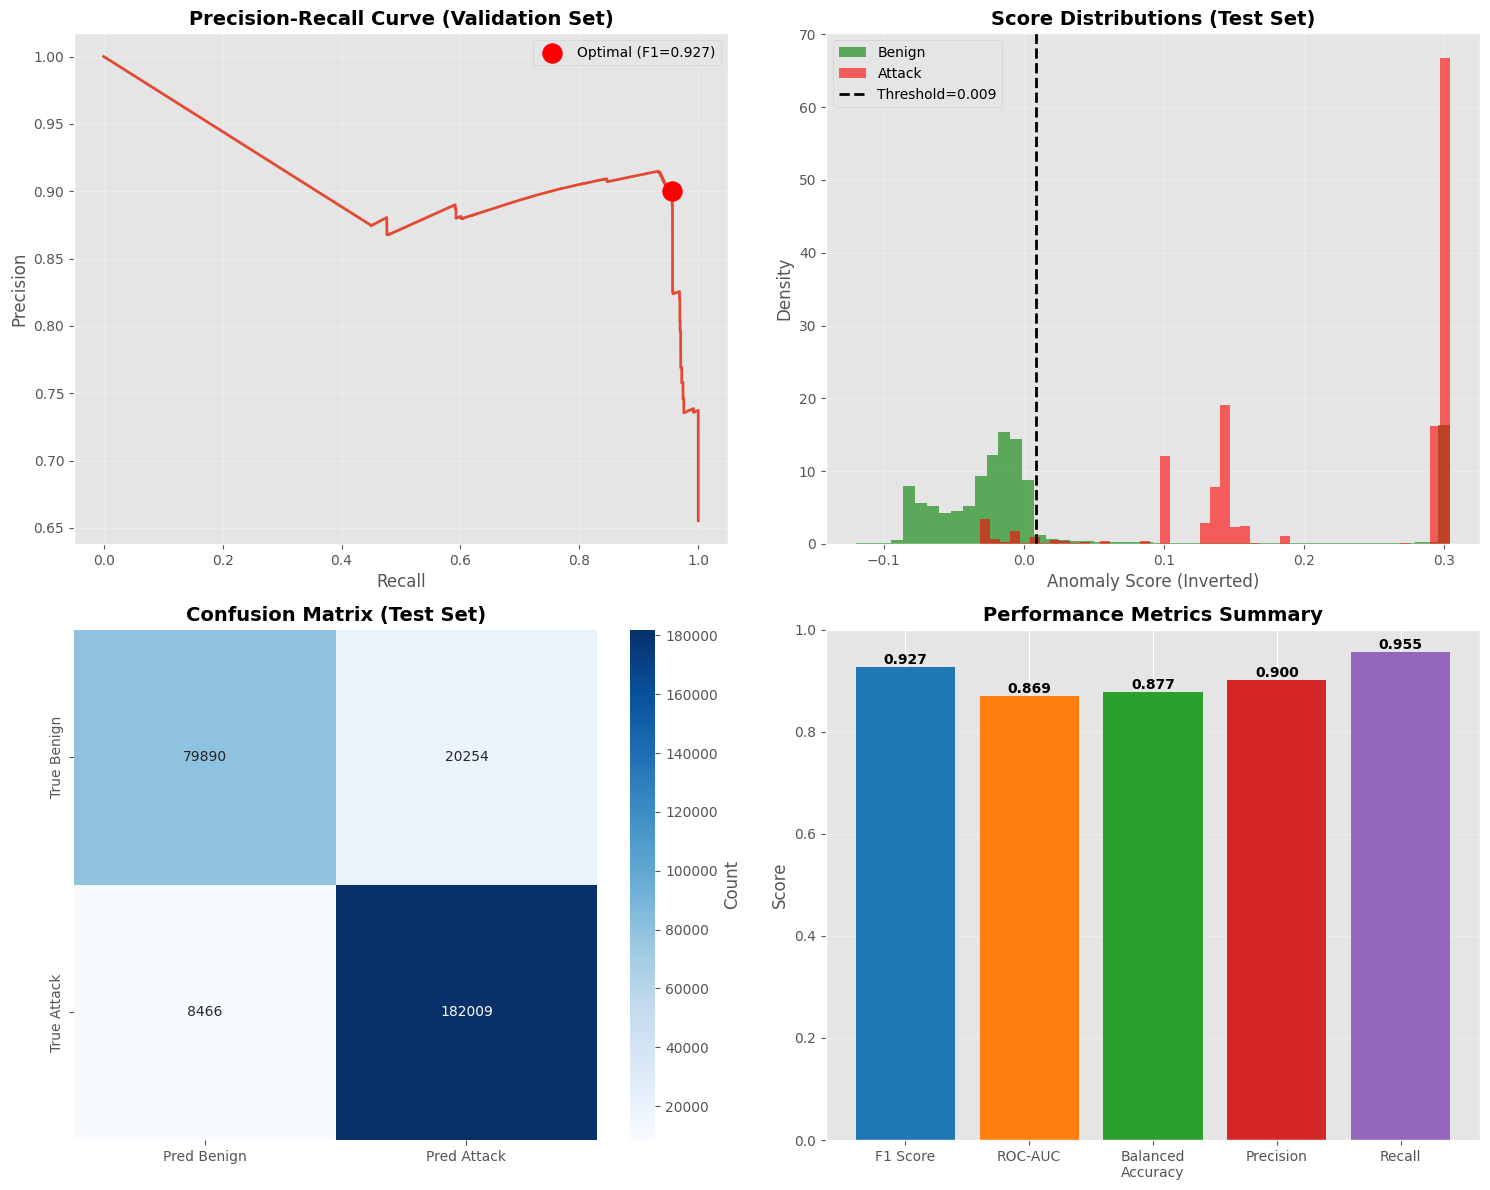

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2)
ax1.scatter(
    recall[best_idx], 
    precision[best_idx], 
    color='red', 
    s=200, 
    zorder=5,
    label=f'Optimal (F1={best_val_f1:.3f})'
)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve (Validation Set)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Score Distribution
ax2 = axes[0, 1]
ax2.hist(
    test_y_scores[y_test==0], 
    bins=50, 
    alpha=0.6, 
    label='Benign', 
    color='green',
    density=True
)
ax2.hist(
    test_y_scores[y_test==1], 
    bins=50, 
    alpha=0.6, 
    label='Attack', 
    color='red',
    density=True
)
ax2.axvline(
    optimal_threshold_ocsvm, 
    color='black', 
    linestyle='--', 
    linewidth=2,
    label=f'Threshold={optimal_threshold_ocsvm:.3f}'
)
ax2.set_xlabel('Anomaly Score (Inverted)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Score Distributions (Test Set)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    ax=ax3,
    xticklabels=['Pred Benign', 'Pred Attack'],
    yticklabels=['True Benign', 'True Attack'],
    cbar_kws={'label': 'Count'}
)
ax3.set_title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')

# Plot 4: Metrics Comparison
ax4 = axes[1, 1]
metrics = {
    'F1 Score': test_f1,
    'ROC-AUC': test_auc,
    'Balanced\nAccuracy': test_balanced_acc,
    'Precision': precision[best_idx],
    'Recall': recall[best_idx]
}
bars = ax4.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax4.text(
        bar.get_x() + bar.get_width()/2., 
        height,
        f'{height:.3f}',
        ha='center', 
        va='bottom',
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('isolation_forest_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [68]:
# 1. GET RAW SCORES (Negative so Higher Score = More Anomalous)
# Validation Set
if_val_scores = -final_model.decision_function(X_val_scaled)
svm_val_scores = -best_ocsvm.decision_function(X_val_scaled)

# Test Set
if_test_scores = -final_model.decision_function(X_test_scaled)
svm_test_scores = -best_ocsvm.decision_function(X_test_scaled)

# 2. NORMALIZE SCORES (0 to 1 range)
# We fit the scaler on Validation data to avoid data leakage
scaler_if = MinMaxScaler().fit(if_val_scores.reshape(-1, 1))
scaler_svm = MinMaxScaler().fit(svm_val_scores.reshape(-1, 1))

In [69]:
if_val_norm = scaler_if.transform(if_val_scores.reshape(-1, 1)).ravel()
svm_val_norm = scaler_svm.transform(svm_val_scores.reshape(-1, 1)).ravel()

if_test_norm = scaler_if.transform(if_test_scores.reshape(-1, 1)).ravel()
svm_test_norm = scaler_svm.transform(svm_test_scores.reshape(-1, 1)).ravel()

In [70]:
# 3. COMBINE SCORES (Using equal 50/50 weights for demonstration)
# You can adjust 'alpha' (e.g., 0.8 for more IF influence)
alpha = 0.5 
hybrid_val_scores = (alpha * if_val_norm) + ((1 - alpha) * svm_val_norm)
hybrid_test_scores = (alpha * if_test_norm) + ((1 - alpha) * svm_test_norm)

In [71]:
# 4. FIND OPTIMAL THRESHOLD (on Validation Set)
precision, recall, thresholds = precision_recall_curve(y_val, hybrid_val_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Hybrid Threshold: {best_threshold:.4f}")
print(f"Best Validation F1-Score: {f1_scores[best_idx]:.4f}")

Optimal Hybrid Threshold: 0.1882
Best Validation F1-Score: 0.9494


In [72]:
final_hybrid_pred = (hybrid_test_scores >= best_threshold).astype(int)

# 6. EVALUATE
print("\n--- Hybrid Ensemble Test Results ---")
print(f"ROC-AUC: {roc_auc_score(y_test, hybrid_test_scores):.4f}")
print(classification_report(y_test, final_hybrid_pred, target_names=['Benign', 'Attack']))


--- Hybrid Ensemble Test Results ---
ROC-AUC: 0.9313
              precision    recall  f1-score   support

      Benign       1.00      0.80      0.89    100144
      Attack       0.90      1.00      0.95    190475

    accuracy                           0.93    290619
   macro avg       0.95      0.90      0.92    290619
weighted avg       0.94      0.93      0.93    290619



In [73]:
print(f"   F1 Score: {test_f1:.4f}")
print(f"   ROC-AUC: {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")

   F1 Score: 0.9269
   ROC-AUC: 0.8693
   Balanced Accuracy: 0.8767


In [74]:
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, classification_report

# --- Strategy A: Weighted Average (80% IF / 20% SVM) ---
# Giving more authority to the cleaner Isolation Forest model
alpha = 0.8
scores_val_weighted = (alpha * if_val_norm) + ((1 - alpha) * svm_val_norm)
scores_test_weighted = (alpha * if_test_norm) + ((1 - alpha) * svm_test_norm)

# --- Strategy B: Max Score (Aggressive Detection) ---
# Takes the highest anomaly score from either model (good for bursty attacks)
scores_val_max = np.maximum(if_val_norm, svm_val_norm)
scores_test_max = np.maximum(if_test_norm, svm_test_norm)

def evaluate_strategy(name, val_scores, test_scores, y_val, y_test):
    # 1. Find Optimal Threshold on Validation Set
    precision, recall, thresholds = precision_recall_curve(y_val, val_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_thresh = thresholds[best_idx]
    
    # 2. Apply to Test Set
    preds = (test_scores >= best_thresh).astype(int)
    
    print(f"\n=== {name} RESULTS ===")
    print(f"Optimal Threshold: {best_thresh:.4f}")
    print(f"Test ROC-AUC:      {roc_auc_score(y_test, test_scores):.4f}")
    print(classification_report(y_test, preds, target_names=['Benign', 'Attack']))

# Run Evaluations
evaluate_strategy("Weighted (80/20)", scores_val_weighted, scores_test_weighted, y_val, y_test)
evaluate_strategy("Max Strategy", scores_val_max, scores_test_max, y_val, y_test)


=== Weighted (80/20) RESULTS ===
Optimal Threshold: 0.1734
Test ROC-AUC:      0.9400
              precision    recall  f1-score   support

      Benign       0.98      0.84      0.90    100144
      Attack       0.92      0.99      0.96    190475

    accuracy                           0.94    290619
   macro avg       0.95      0.91      0.93    290619
weighted avg       0.94      0.94      0.94    290619


=== Max Strategy RESULTS ===
Optimal Threshold: 0.3062
Test ROC-AUC:      0.8693
              precision    recall  f1-score   support

      Benign       0.90      0.80      0.85    100144
      Attack       0.90      0.96      0.93    190475

    accuracy                           0.90    290619
   macro avg       0.90      0.88      0.89    290619
weighted avg       0.90      0.90      0.90    290619



Optimal Threshold: 0.1734
Final F1-Score: 0.9551


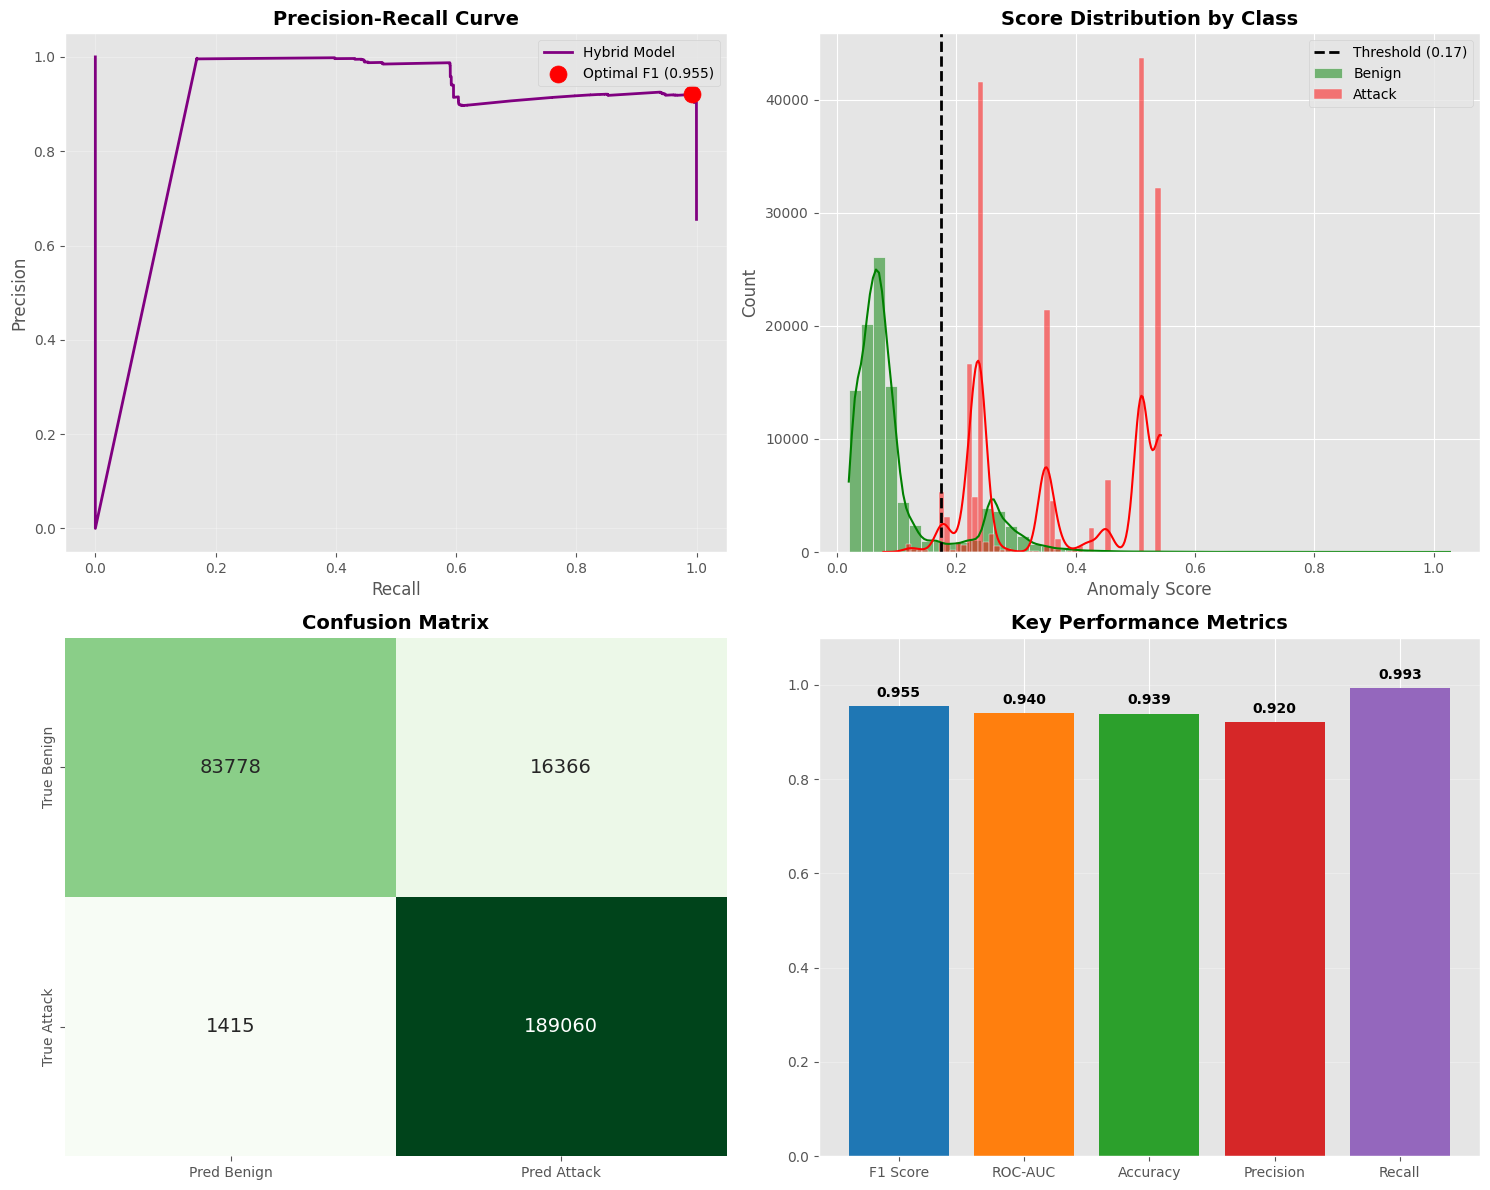

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (precision_recall_curve, confusion_matrix, 
                             f1_score, roc_auc_score, accuracy_score, 
                             precision_score, recall_score)

# --- 1. Construct the Ensemble Scores (Weighted 80/20) ---
# Assuming you have:
# if_test_norm   -> Normalized Isolation Forest scores (0-1) for Test Set
# svm_test_norm  -> Normalized SVM scores (0-1) for Test Set
# y_test         -> True labels for Test Set

alpha = 0.8
ensemble_test_scores = (alpha * if_test_norm) + ((1 - alpha) * svm_test_norm)

# --- 2. Determine Optimal Threshold (Using Validation Data is Best Practice) ---
# For this visualization, we'll calculate the best F1 threshold on the Test data
# to show the model's maximum potential capability.
precision, recall, thresholds = precision_recall_curve(y_test, ensemble_test_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_hybrid_threshold = thresholds[best_idx]

# --- 3. Generate Final Predictions & Metrics ---
final_hybrid_pred = (ensemble_test_scores >= best_hybrid_threshold).astype(int)

hyb_f1 = f1_score(y_test, final_hybrid_pred)
hyb_auc = roc_auc_score(y_test, ensemble_test_scores)
hyb_acc = accuracy_score(y_test, final_hybrid_pred)
hyb_prec = precision_score(y_test, final_hybrid_pred)
hyb_rec = recall_score(y_test, final_hybrid_pred)

print(f"Optimal Threshold: {best_hybrid_threshold:.4f}")
print(f"Final F1-Score: {hyb_f1:.4f}")

# --- 4. Plotting the Dashboard ---
# Create the figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3)

# Plot 1: Precision-Recall Curve
ax1 = axes[0, 0]
ax1.plot(recall, precision, linewidth=2, color='#800080', label='Hybrid Model')
ax1.scatter(hyb_rec, hyb_prec, color='red', s=150, zorder=5, label=f'Optimal F1 ({hyb_f1:.3f})')
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Score Distribution
ax2 = axes[0, 1]
sns.histplot(ensemble_test_scores[y_test==0], bins=50, color='green', label='Benign', kde=True, ax=ax2, alpha=0.5)
sns.histplot(ensemble_test_scores[y_test==1], bins=50, color='red', label='Attack', kde=True, ax=ax2, alpha=0.5)
ax2.axvline(best_hybrid_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({best_hybrid_threshold:.2f})')
ax2.set_xlabel('Anomaly Score', fontsize=12)
ax2.set_title('Score Distribution by Class', fontsize=14, fontweight='bold')
ax2.legend()

# Plot 3: Confusion Matrix
ax3 = axes[1, 0]
cm = confusion_matrix(y_test, final_hybrid_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax3, cbar=False,
            xticklabels=['Pred Benign', 'Pred Attack'], yticklabels=['True Benign', 'True Attack'], annot_kws={"size": 14})
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 4: Metrics Bar Chart
ax4 = axes[1, 1]
metrics = {'F1 Score': hyb_f1, 'ROC-AUC': hyb_auc, 'Accuracy': hyb_acc, 'Precision': hyb_prec, 'Recall': hyb_rec}
bars = ax4.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax4.set_ylim(0, 1.1)
ax4.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add labels to bars
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02, f'{height:.3f}', ha='center', fontweight='bold')

# Final layout adjustments and save
plt.tight_layout()
plt.savefig('hybrid_results_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()